In [17]:
import pandas as pd
import numpy as np
import seaborn as sns

url_email_obs = "https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/email_obs_data.csv"
url_email_rnd = "https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/email_rnd_data.csv"

data_biased = pd.read_csv(url_email_obs)
data_rnd = pd.read_csv(url_email_rnd)

In [8]:
y = "next_mnth_pv"
T = "mkt_email"
X = list(data_rnd.drop(columns=[y, T]).columns)

train, test = data_biased, data_rnd

## T-Learner

In [19]:
from lightgbm import LGBMRegressor

np.random.seed(123)
m0 = LGBMRegressor()
m1 = LGBMRegressor()

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

In [20]:

from toolz import curry

@curry
def effect(data, y, t):
    return (np.sum((data[t] - data[t].mean()) * data[y]) / sum( (data[t] - data[t].mean())**2 ))

def cumulative_gain_curve(df, prediction, y, t, ascending=False, normalize=False, steps=100):
    effect_fn = effect(t = t, y = y)
    normalizer = effect_fn(df) if normalize else 0

    size = len(df)
    ordered_df = (df
                  .sort_values(prediction, ascending=ascending)
                  .reset_index(drop=True))
    
    steps = np.linspace(size / steps, size, steps).round(0)
    effects = [(effect_fn(ordered_df.query(f"index <= {row}")) - normalizer) * (row / size) for row in steps]

    return np.array([0] + effects)

In [22]:
np.trapz(cumulative_gain_curve(t_learner_cate_test, "cate", y, T, normalize=True))

10532.16173183944

## X Learner

In [26]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor

# Propensity score model
ps_model = LogisticRegression(penalty="none")
ps_model.fit(train[X], train[T])

# First stage models
train_t0 = train.query(f"{T}==0")
train_t1 = train.query(f"{T}==1")

m0 = LGBMRegressor()
m1 = LGBMRegressor()

np.random.seed(123)

m0.fit(train_t0[X], train_t0[y], sample_weight=1 / ps_model.predict_proba(train_t0[X])[:, 0])
m1.fit(train_t1[X], train_t1[y], sample_weight=1 / ps_model.predict_proba(train_t1[X])[:, 1])

# Second stage
tau_hat_0 = m1.predict(train_t0[X]) - train_t0[y]
tau_hat_1 = m0.predict(train_t1[X]) - train_t1[y]

m_tau_0 = LGBMRegressor()
m_tau_1 = LGBMRegressor()

np.random.seed(123)

m_tau_0.fit(train_t0[X], tau_hat_0)
m_tau_1.fit(train_t1[X], tau_hat_1)

# estimate the Cate
ps_test = ps_model.predict_proba(test[X])[:, 1]
x_cate_test = test.assign(
    cate = (ps_test * m_tau_0.predict(test[X]) + (1 - ps_test)*m_tau_1.predict(test[X]))
)


In [27]:
np.trapz(cumulative_gain_curve(x_cate_test, "cate", y, T, normalize=True))

3083.5822393048334

# Meta-learners for continuous treatment

In [5]:
url_discount = "https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/discount_data.csv"

data_cont = pd.read_csv(url_discount)
data_cont.head()

#Treatment: discounts
# Outcome: sales

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales
0,0,2016-01-01,1,4,False,True,False,False,2.88,0,79.0
1,0,2016-01-02,1,5,True,False,False,False,2.64,0,57.0
2,0,2016-01-03,1,6,True,False,False,False,2.08,5,294.0
3,0,2016-01-04,1,0,False,False,False,False,3.37,15,676.5
4,0,2016-01-05,1,1,False,False,False,False,3.79,0,66.0


In [6]:
train = data_cont.query("day<'2018-01-01'")
test = data_cont.query("day>='2018-01-01'")

## S-Learner

In [10]:
from lightgbm import LGBMRegressor

X = ["month", "weekday", "is_holiday", "competitors_price"]
T = "discounts"
y = "sales"

np.random.seed(123)
s_learner = LGBMRegressor()
s_learner.fit(train[X + [T]], train[y])

LGBMRegressor()

In [11]:
train[T].describe()

count    5117.000000
mean       10.285323
std         9.717807
min         0.000000
25%         0.000000
50%        10.000000
75%        15.000000
max        45.000000
Name: discounts, dtype: float64

In [12]:
t_grid = pd.DataFrame(dict(key = 1, discounts=np.array([0, 10, 20, 30, 40])))
test_cf = (test
           .drop(columns=["discounts"])
           .assign(key=1)
           .merge(t_grid)
           .assign(sales_hat = lambda d: s_learner.predict(d[X + [T]]))
           )
test_cf.head(8)

,rest_id,day,month,weekday,weekend,is_holiday,is_dec,is_nov,competitors_price,sales,key,discounts,sales_hat
0,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,0,67.957972
1,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,10,444.245941
2,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,20,793.045769
3,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,30,1279.640793
4,0,2018-01-01,1,0,False,True,False,False,4.92,251.5,1,40,1512.630767
5,0,2018-01-02,1,1,False,False,False,False,3.06,541.0,1,0,65.672080
6,0,2018-01-02,1,1,False,False,False,False,3.06,541.0,1,10,495.669220
7,0,2018-01-02,1,1,False,False,False,False,3.06,541.0,1,20,1015.401471


In [13]:
from toolz import curry

@curry
def linear_effect(df, y, t):
    return np.cov(df[y], df[t])[0, 1] / df[t].var()

cate = (test_cf
        .groupby(["rest_id", "day"])
        .apply(linear_effect(t = "discounts", y="sales_hat"))
        .rename("cate")
        )

test_s_learner_pred = test.set_index(["rest_id", "day"]).join(cate)
test_s_learner_pred.head()

month  weekday  weekend  is_holiday  is_dec  is_nov  \
rest_id day                                                               
0       2018-01-01      1        0    False        True   False   False   
        2018-01-02      1        1    False       False   False   False   
        2018-01-03      1        2    False       False   False   False   
        2018-01-04      1        3    False       False   False   False   
        2018-01-05      1        4    False       False   False   False   

                    competitors_price  discounts  sales       cate  
rest_id day                                                         
0       2018-01-01               4.92          5  251.5  37.247404  
        2018-01-02               3.06         10  541.0  40.269854  
        2018-01-03               4.61         10  431.0  37.412988  
        2018-01-04               4.84         20  760.0  38.436815  
        2018-01-05               6.29          0   78.0  31.428603

168.02737967191334


<Axes: >

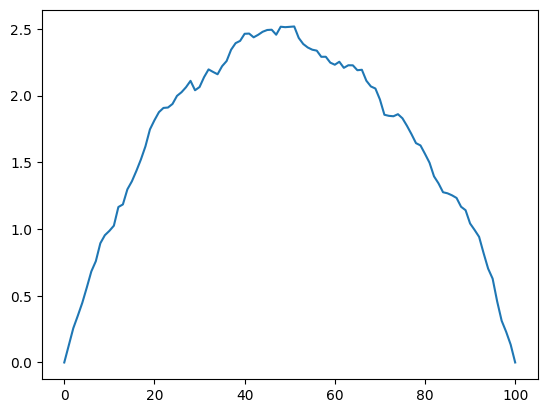

In [20]:
@curry
def effect(data, y, t):
    return (np.sum((data[t] - data[t].mean()) * data[y]) / sum( (data[t] - data[t].mean())**2 ))

def cumulative_gain_curve(df, prediction, y, t, ascending=False, normalize=False, steps=100):
    effect_fn = effect(t = t, y = y)
    normalizer = effect_fn(df) if normalize else 0

    size = len(df)
    ordered_df = (df
                  .sort_values(prediction, ascending=ascending)
                  .reset_index(drop=True))
    
    steps = np.linspace(size / steps, size, steps).round(0)
    effects = [(effect_fn(ordered_df.query(f"index <= {row}")) - normalizer) * (row / size) for row in steps]

    return np.array([0] + effects)


print(np.trapz(cumulative_gain_curve(test_s_learner_pred, "cate", "sales", "discounts", normalize=True)))
sns.lineplot(cumulative_gain_curve(test_s_learner_pred, "cate", "sales", "discounts", normalize=True))
